# Interpretability of heartbeat classification using a CNN model and Grad-CAM

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations
from itertools import islice
from sklearn.preprocessing import normalize
sns.set()

length = 277

### Extract task-specific data and one-hot encode labels

In [2]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
# Using GPU
import os
import scipy.io as scpy

data = scpy.loadmat("matlab15000.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["unnamed"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_data = np.array(y_data,dtype='float32')
# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=SEED)


x_val = x_test[:1500]
y_val = y_test[:1500]
x_test_to_use = x_test[1500:]
y_test_to_use = y_test[1500:]
print(f" {len(x_train), len(x_val), len(x_test_to_use)}")

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


(15000, 1000)
(15000, 1)
 (12000, 1500, 1500)


In [4]:
print(x_train.shape[1])

1000


### Build the CNN architecture, train, and predict on the test set

In [14]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 10, 64
activationFunction='relu'

def getModel(): 
    cnnmodel = Sequential()
    cnnmodel.add(tf.keras.layers.Reshape((x_train.shape[1],1), input_shape=(1000,)))
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(x_train.shape[1],)))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu', name = 'last_conv_layer'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(3, activation='softmax'))
    cnnmodel.summary()
    cnnmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return cnnmodel

cnnmodel = getModel()
cnnhistory= cnnmodel.fit(x_train, y_train, epochs=epoch, verbose=verbose, validation_data=(x_val, y_val), batch_size = batch_size)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 1000, 1)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 1000, 128)         2176      
                                                                 
 batch_normalization_14 (Bat  (None, 1000, 128)        512       
 chNormalization)                                                
                                                                 
 last_conv_layer (Conv1D)    (None, 1000, 9)           18441     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 250, 9)           0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 2250)             

In [68]:
# # Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_gradcamcam_ecg_paper.h5')

### Choose a class to get the Grad-CAM values for

In [90]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 8
class_ann = 'I'

N_test = test_values[test_values[:,-2]==class_num]

X_test = N_test[:,:-2]
y_test = N_test[:len(N_test),-2]

X_test1 = X_test.reshape(-1, x_train.shape[1], 1)
y_test1 = to_categorical(y_test)
cnnpredictions = cnnmodel.predict(X_test1, verbose=1)

76/76 [==============================] - 0s 6ms/step


### Create a performance metrics function

In [91]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

### Call the performance metrics function per class

C:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-92-42e0dbbe1108>:8: RuntimeWarning: invalid value encountered in true_divide
  CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]


Accuracy  : 0.9887827170751974
Precision : 0.2
Recall : 0.19775654341503948
f1score : 0.19887194485063714


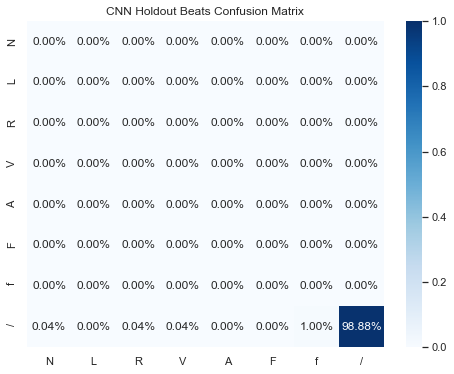

In [92]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')

# Plot confusion matrix:
categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(CNN_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='Blues')
plt.title('CNN Holdout Beats Confusion Matrix')
plt.show()
fig.savefig('cm.jpg', dpi = 400)

### Compute Grad-CAM values for the class chosen above

In [93]:
# Turn off the final Softmax activation function:
cnnmodel.layers[-1].activation = None

In [94]:
# Create a model that maps the input heartbeat to the feature maps of the last convolutional layer 
# and the output (before applying Softmax):
grad_model = tf.keras.models.Model([cnnmodel.inputs], [cnnmodel.get_layer('last_conv_layer').output, cnnmodel.output])

# Step 1: Compute the gradient of the output with respect to the feature maps:
with tf.GradientTape() as tape:
    last_conv_layer_features, y_predictions = grad_model(X_test1)
grads = tape.gradient(y_predictions, last_conv_layer_features)

# Step 2: Calculate alpha values by averaging the gradients:
alpha_values = tf.reduce_mean(grads, axis = 1)

# Step 3: Use the alpha values as the weight of the corresponding feature map: 
gradcam = tf.linalg.matmul(last_conv_layer_features, alpha_values[..., tf.newaxis])

In [95]:
# Normalize the grad-CAM values for visualization:
gradcam = gradcam.numpy()
gradcam = np.abs(gradcam)
gradcam_norm = (gradcam - np.min(gradcam, axis = 1, keepdims = True)) / (np.max(gradcam, axis = 1, keepdims = True) - 
                                                        np.min(gradcam, axis = 1, keepdims = True))
y_predictions = tf.nn.softmax(y_predictions)
y_predictions = y_predictions.numpy()

### Visualize Grad-CAM results with saliency maps for the correctly classified beats

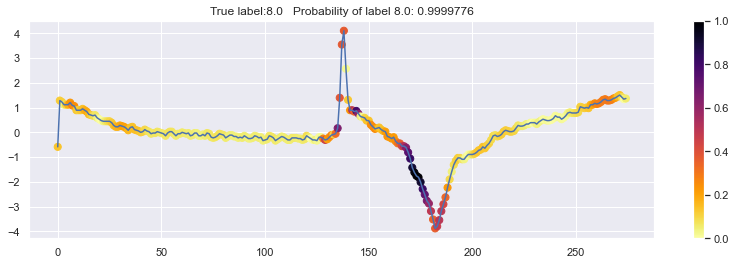

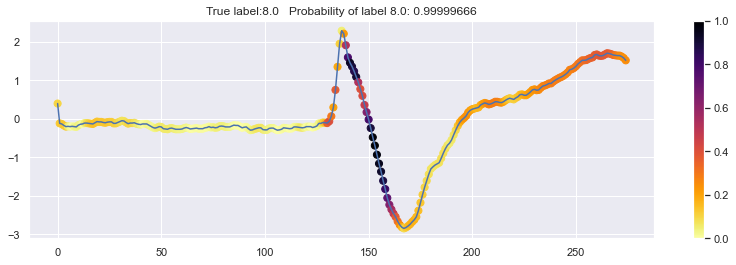

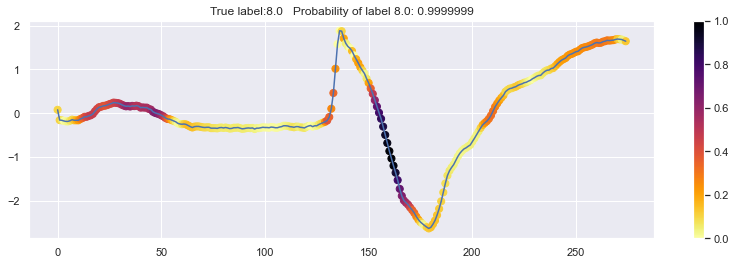

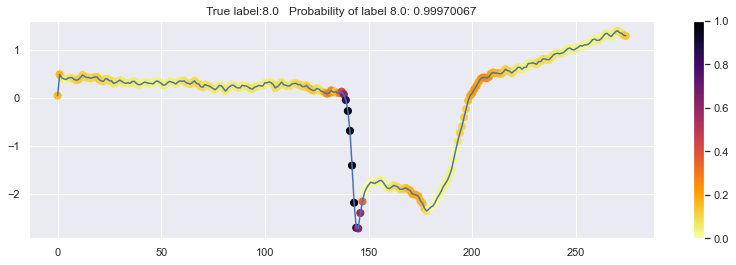

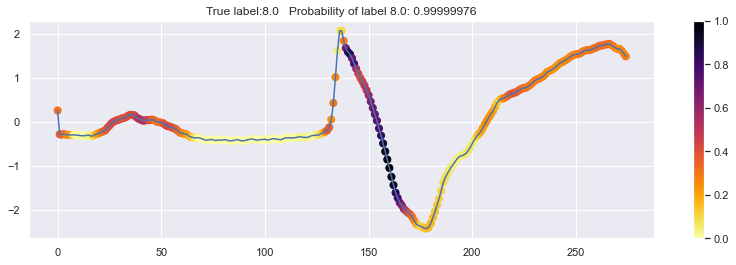

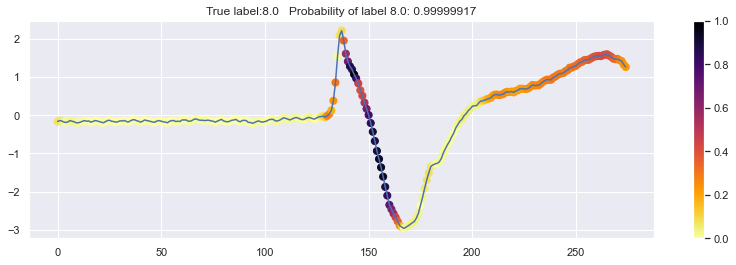

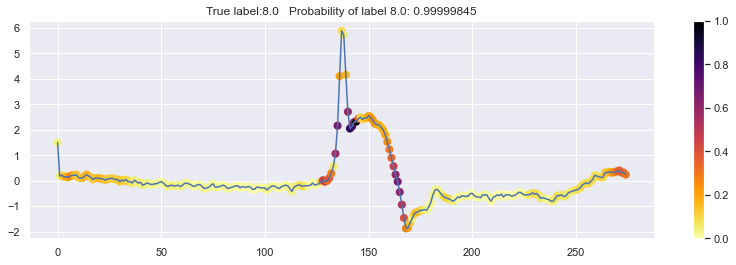

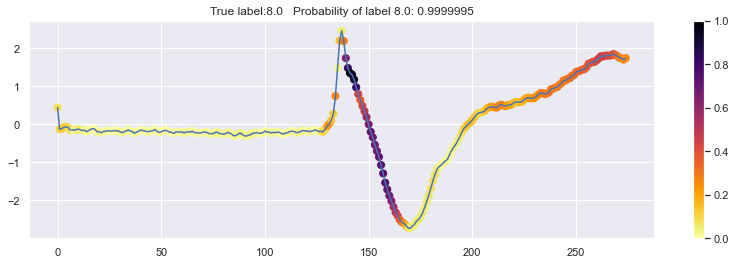

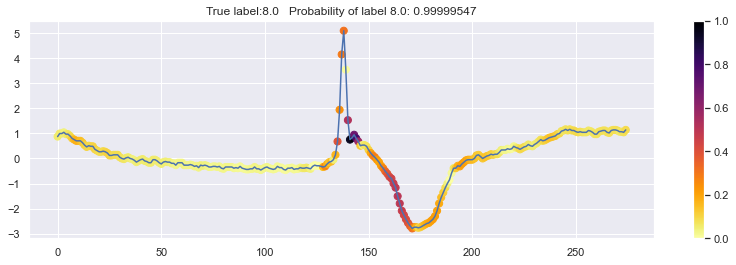

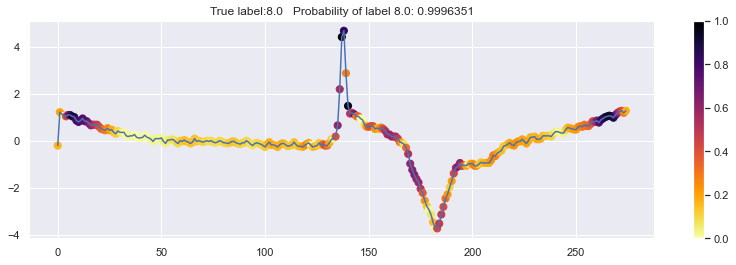

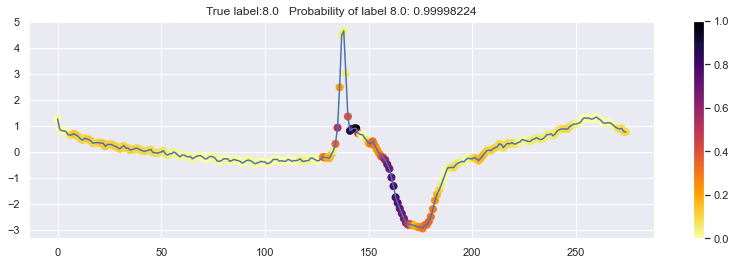

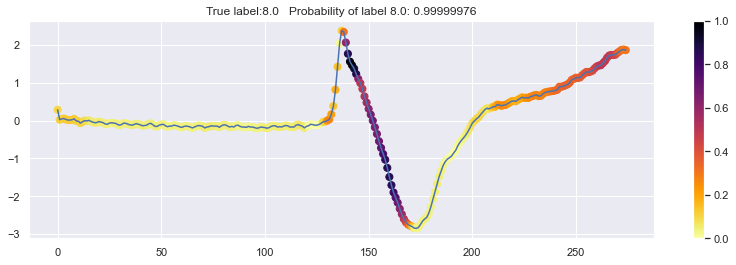

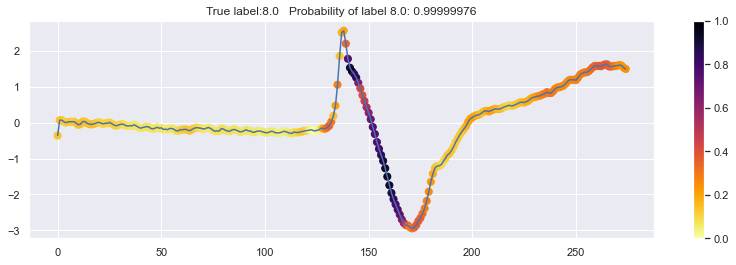

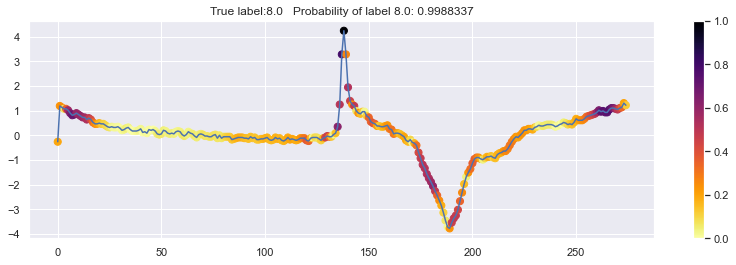

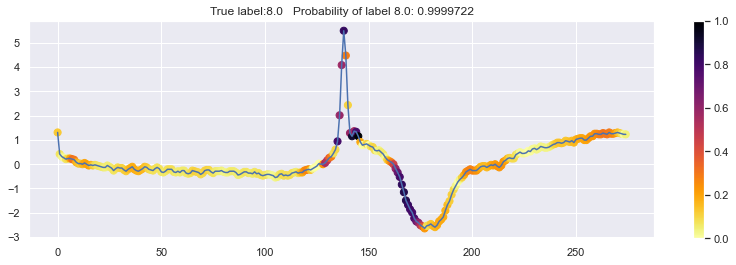

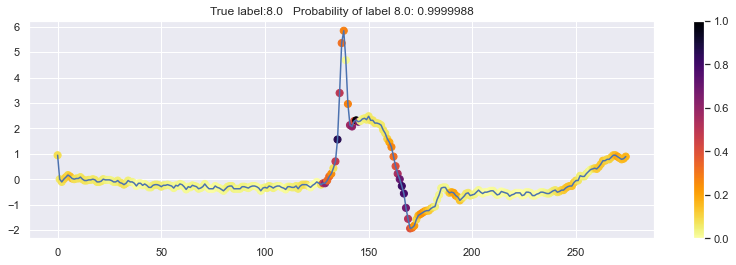

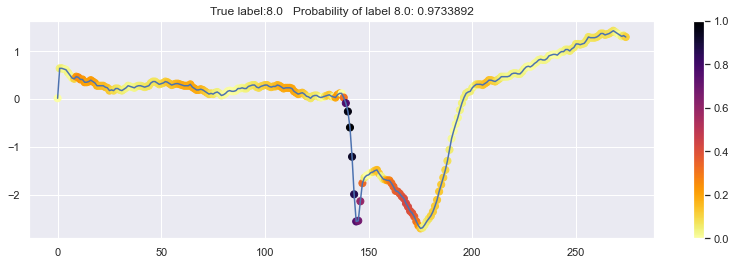

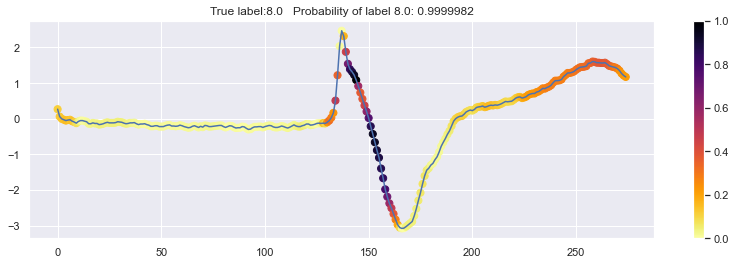

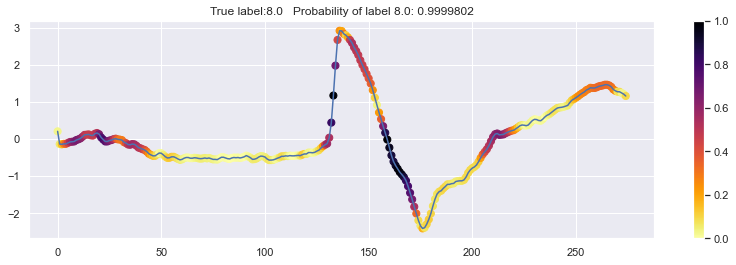

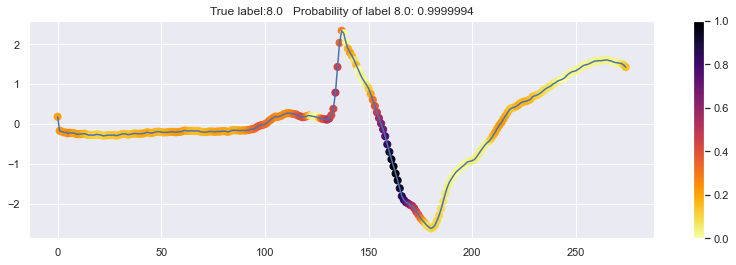

In [96]:
# Get the corectly classified data:
correct_cnn = np.where(cnn_predict == cnn_actual_value)
correct_cnn = correct_cnn[0].tolist()

# Plot a few examples of heatmaps:
for i in correct_cnn[20:40]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(y_predictions[i, int(y_test[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Visualize Grad-CAM results with saliency maps for the heartbeats that were not correctly classified

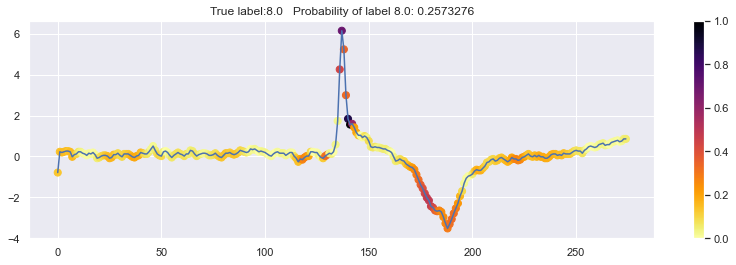

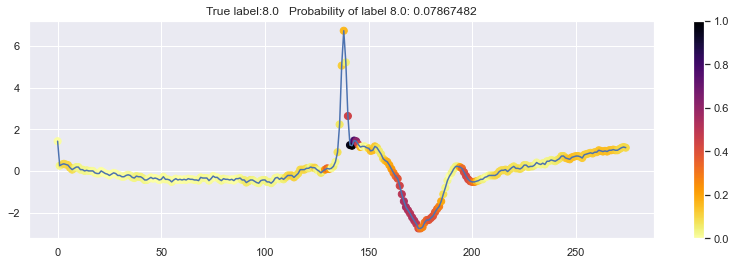

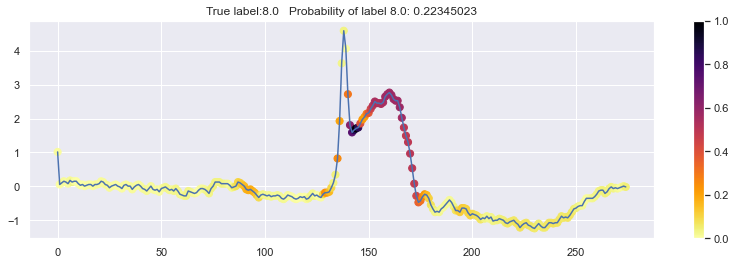

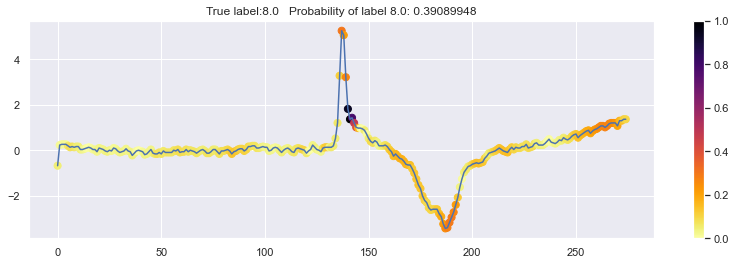

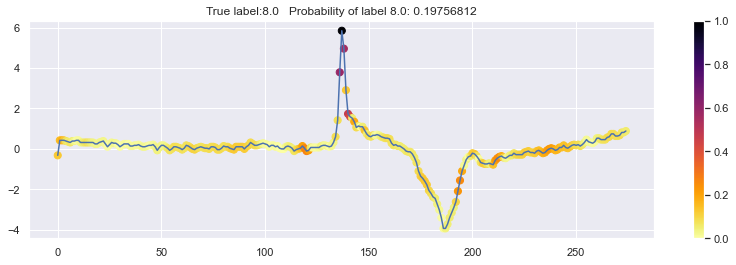

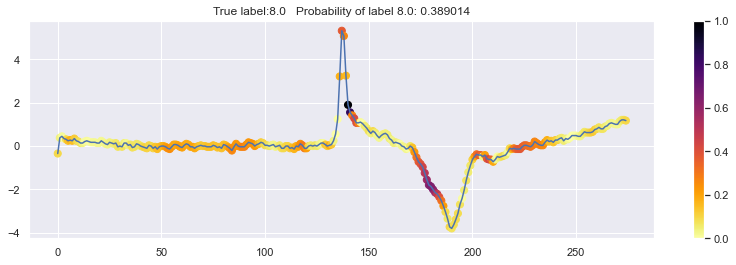

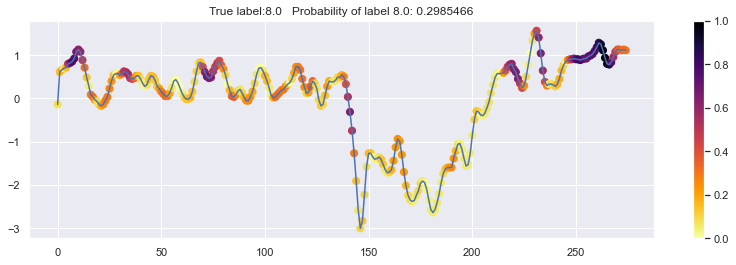

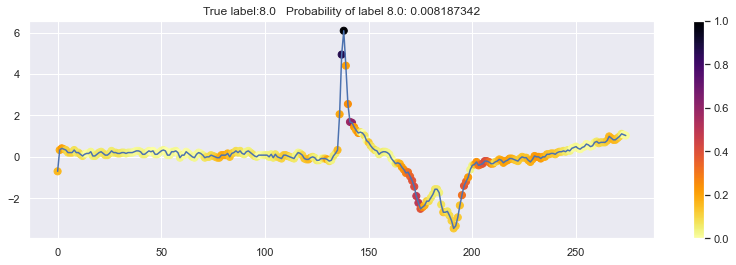

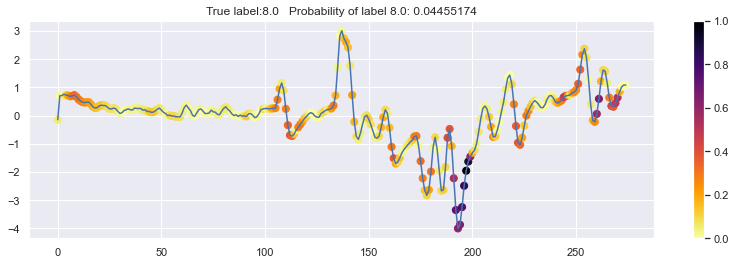

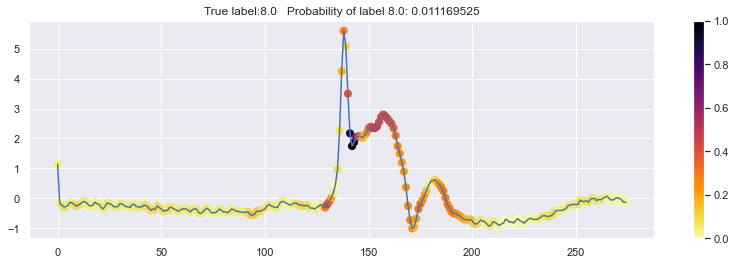

In [97]:
# Get the misclassified data:
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)
misclass_cnn = misclass_cnn[0].tolist()

# Plot a few examples of heatmaps:
for i in misclass_cnn[:10]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(y_predictions[i, int(y_test[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Divide the  ECG beats into 11 segments and compute the Grad-CAM values per segment

In [98]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Divide the result into slices:
cam_per_segment = []
for i in range(X_test1.shape[0]):
    means = list(means_of_slices(gradcam_norm[i], 25))
    cam_per_segment.append(means)
cam_per_segment = np.array(cam_per_segment)
print(cam_per_segment.shape)

# Repeat the values 25 times for visualization purposes:
cam_per_segment_repeat = []
for i in cam_per_segment:
    cam_per_segment_repeat.append(np.repeat(i,25))
cam_per_segment_repeat = np.array(cam_per_segment_repeat)
print(cam_per_segment_repeat.shape)

(2407, 11)
(2407, 275)


### Plot the average Grad-CAM values per segment on a sample ECG beat

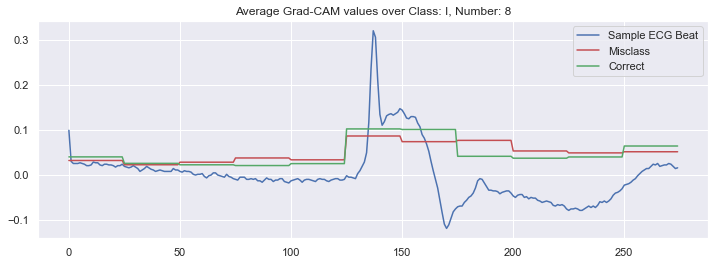

In [99]:
# Normalize correct and incorrect predictions:
ecg_correct_norm = normalize(cam_per_segment_repeat[correct_cnn[:1000]])
ecg_incorrect_norm = normalize(cam_per_segment_repeat[misclass_cnn[:10]])

# Normalize ECG heartbeat example:
ecg_norm = normalize(X_test1[:,:,0])

# Take means of all correct and incorrect segments:
mean_correct = ecg_correct_norm.mean(axis=0)
mean_incorrect = ecg_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ecg_norm[1],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average Grad-CAM values over '+'Class: ' + class_ann +', Number: ' + str(class_num))
plt.legend()
plt.savefig('cnn_gradcam_' + class_ann + '.jpg', bbox_inches='tight',dpi=400)
plt.show()